<a href="https://colab.research.google.com/github/zrruziev/Deep_Learning_Practice/blob/main/TDC/C4_W4_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Imports

In [1]:
import csv
import pickle
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from dataclasses import dataclass

##Download the dataset 

In [2]:
!wget --no-check-certificate \
    https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv

--2022-05-02 07:29:32--  https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 67921 (66K) [text/plain]
Saving to: ‘daily-min-temperatures.csv’

daily-min-temperatu 100%[===================>]  66.33K  --.-KB/s    in 0.01s   

2022-05-02 07:29:33 (4.39 MB/s) - ‘daily-min-temperatures.csv’ saved [67921/67921]



In [4]:
TEMPERATURES_CSV = './daily-min-temperatures.csv'

with open(TEMPERATURES_CSV, 'r') as csvfile:
    print(f"Header looks like this:\n\n{csvfile.readline()}")    
    print(f"First data point looks like this:\n\n{csvfile.readline()}")
    print(f"Second data point looks like this:\n\n{csvfile.readline()}")

Header looks like this:

"Date","Temp"

First data point looks like this:

"1981-01-01",20.7

Second data point looks like this:

"1981-01-02",17.9



In the first exercise you will code a function to read the data from the csv but for now run the next cell to load a helper function to plot the time series.



In [5]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [20]:
with open('./daily-min-temperatures.csv') as csvfile:
        reader = csv.reader(csvfile, delimiter=',')
        next(reader)
        x = []
        for row in reader:
            x.append(row)
        print(f'The number of timeseries data: {len(x)} ')


The number of timeseries data: 3650 


##Parsing the raw data


In [30]:
def parse_data_from(filename):
    times = []
    temperatures = []

    with open(filename) as csvfile:
        reader = csv.reader(csvfile, delimiter=',')
        next(reader)
        for index, row in enumerate(reader):
            times.append(index)
            temperatures.append(float(row[1]))

    return times, temperatures


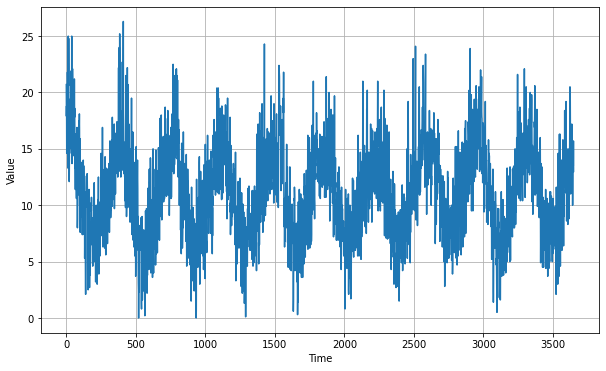

[0 1 2 3 4 5 6 7 8 9]
[20.7 17.9 18.8 14.6 15.8 15.8 15.8 17.4 21.8 20. ]


In [31]:
# Test the function
@dataclass
class G:
    TEMPERATURES_CSV = './daily-min-temperatures.csv'
    times, temperatures = parse_data_from(TEMPERATURES_CSV)
    TIME = np.array(times)
    SERIES = np.array(temperatures)
    SPLIT_TIME = 2500
    WINDOW_SIZE = 64
    BATCH_SIZE = 256
    SHUFFLE_BUFFER_SIZE = 1000


plt.figure(figsize=(10,6))
plot_series(G.TIME, G.SERIES)
plt.show()

print(G.TIME[:10])
print(G.SERIES[:10])


##Processing the data


In [32]:
def train_val_split(time, series, time_step=G.SPLIT_TIME):

    time_train = time[:time_step]
    series_train = series[:time_step]
    time_valid = time[time_step:]
    series_valid = series[time_step:]

    return time_train, series_train, time_valid, series_valid


# Split the dataset
time_train, series_train, time_valid, series_valid = train_val_split(G.TIME, G.SERIES)

In [33]:
def windowed_dataset(series, window_size=G.WINDOW_SIZE, batch_size=G.BATCH_SIZE, shuffle_buffer=G.SHUFFLE_BUFFER_SIZE):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1]))
    ds = ds.batch(batch_size).prefetch(1)
    return ds


# Apply the transformation to the training set
train_set = windowed_dataset(series_train)

##Defining the model architecture


In [42]:
def create_uncompiled_model():
    tf.keras.backend.clear_session()
    tf.random.set_seed(51)
    np.random.seed(51)

    model = tf.keras.models.Sequential([
            tf.keras.layers.Conv1D(64, kernel_size=3, padding='causal', activation='relu', input_shape=[G.WINDOW_SIZE, 1]),
            tf.keras.layers.LSTM(64, return_sequences=True),
            tf.keras.layers.LSTM(64),
            tf.keras.layers.Dense(32),
            tf.keras.layers.Dense(16),
            tf.keras.layers.Dense(1, activation='relu'),
            tf.keras.layers.Lambda(lambda x: x*100.0)
            ])
    
    return model


In [43]:
# Test your uncompiled model
uncompiled_model = create_uncompiled_model()

try:
    uncompiled_model.predict(train_set)
except:
    print("Your current architecture is incompatible with the windowed dataset, try adjusting it.")
else:
    print("Your current architecture is compatible with the windowed dataset! :)")

Your current architecture is compatible with the windowed dataset! :)


##Adjusting the learning rate - (Optional Exercise)

In [44]:
def adjust_learning_rate(dataset):
    
    model = create_uncompiled_model()
    
    lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-7 * 10**(epoch / 20))
    
    ### START CODE HERE
    
    # Select your optimizer
    optimizer = tf.keras.optimizers.SGD(momentum=.9)
    
    # Compile the model passing in the appropriate loss
    model.compile(loss=tf.keras.losses.Huber(),
                  optimizer=optimizer, 
                  metrics=["mae"]) 
    
    ### END CODE HERE
    
    history = model.fit(dataset, epochs=100, callbacks=[lr_schedule])
    
    return history

In [45]:
# Run the training with dynamic LR
lr_history = adjust_learning_rate(train_set)

Epoch 1/100
10/10 [==============================] - 7s 47ms/step - loss: 3.3884 - mae: 3.8590 - lr: 1.0000e-07
Epoch 2/100
10/10 [==============================] - 1s 55ms/step - loss: 3.2323 - mae: 3.7013 - lr: 1.1220e-07
Epoch 3/100
10/10 [==============================] - 1s 55ms/step - loss: 3.1952 - mae: 3.6646 - lr: 1.2589e-07
Epoch 4/100
10/10 [==============================] - 1s 51ms/step - loss: 3.1271 - mae: 3.5955 - lr: 1.4125e-07
Epoch 5/100
10/10 [==============================] - 1s 51ms/step - loss: 3.0637 - mae: 3.5307 - lr: 1.5849e-07
Epoch 6/100
10/10 [==============================] - 1s 49ms/step - loss: 2.9966 - mae: 3.4636 - lr: 1.7783e-07
Epoch 7/100
10/10 [==============================] - 1s 52ms/step - loss: 2.9153 - mae: 3.3808 - lr: 1.9953e-07
Epoch 8/100
10/10 [==============================] - 1s 51ms/step - loss: 2.8360 - mae: 3.3011 - lr: 2.2387e-07
Epoch 9/100
10/10 [==============================] - 1s 53ms/step - loss: 2.7545 - mae: 3.2183 - lr: 2.5

(1e-07, 0.0001, 0.0, 10.0)

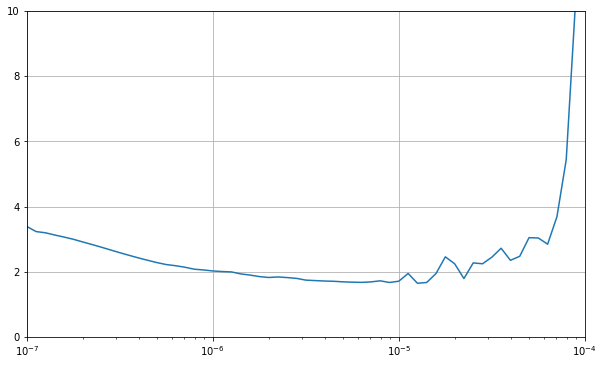

In [49]:
plt.figure(figsize=(10,6))
plt.grid(True)
plt.semilogx(lr_history.history["lr"], lr_history.history["loss"])
plt.axis([1e-7, 1e-4, 0, 10])

##Compile the model with choosen Learning Rate


In [50]:
model = create_uncompiled_model()

model.compile(loss=tf.keras.losses.Huber(),
             optimizer=tf.keras.optimizers.SGD(learning_rate=9e-6, momentum=.9),
             metrics=['mae'])

# Train it
history = model.fit(train_set, epochs=50)

Epoch 1/50
10/10 [==============================] - 4s 45ms/step - loss: 2.8664 - mae: 3.3337
Epoch 2/50
10/10 [==============================] - 1s 54ms/step - loss: 2.0854 - mae: 2.5430
Epoch 3/50
10/10 [==============================] - 1s 53ms/step - loss: 2.0673 - mae: 2.5278
Epoch 4/50
10/10 [==============================] - 1s 51ms/step - loss: 1.9250 - mae: 2.3780
Epoch 5/50
10/10 [==============================] - 1s 53ms/step - loss: 1.9473 - mae: 2.4021
Epoch 6/50
10/10 [==============================] - 1s 53ms/step - loss: 2.2534 - mae: 2.7145
Epoch 7/50
10/10 [==============================] - 1s 52ms/step - loss: 1.9330 - mae: 2.3869
Epoch 8/50
10/10 [==============================] - 1s 54ms/step - loss: 1.7314 - mae: 2.1818
Epoch 9/50
10/10 [==============================] - 1s 52ms/step - loss: 1.7458 - mae: 2.1953
Epoch 10/50
10/10 [==============================] - 1s 52ms/step - loss: 1.6656 - mae: 2.1117
Epoch 11/50
10/10 [==============================] - 1s 52m

##Evaluating the forecast

#####Faster model forecasts

In [51]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

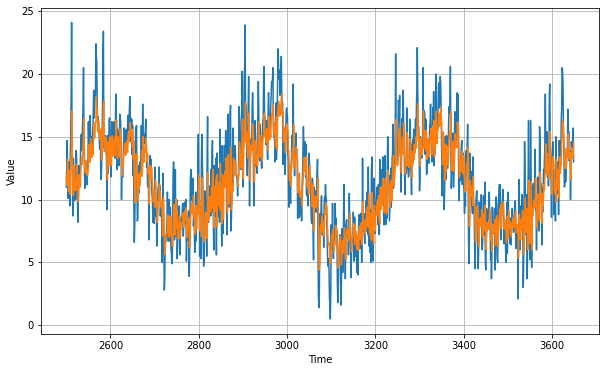

In [52]:
# Compute the forecast for all the series
rnn_forecast = model_forecast(model, G.SERIES, G.WINDOW_SIZE).squeeze()

# Slice the forecast to get only the predictions for the validation set
rnn_forecast = rnn_forecast[G.SPLIT_TIME - G.WINDOW_SIZE:-1]


# Plot the forecast
plt.figure(figsize=(10, 6))
plot_series(time_valid, series_valid)
plot_series(time_valid, rnn_forecast)

In [53]:
def compute_metrics(true_series, forecast):
    
    mse = tf.keras.metrics.mean_squared_error(true_series, forecast).numpy()
    mae = tf.keras.metrics.mean_absolute_error(true_series, forecast).numpy()

    return mse, mae

In [54]:
mse, mae = compute_metrics(series_valid, rnn_forecast)

print(f"mse: {mse:.2f}, mae: {mae:.2f} for forecast")

mse: 5.40, mae: 1.81 for forecast
